In [1]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

input_mzml_files = sorted(glob.glob('results/interim/*.mzML'))

raw_data=[]
for filename in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    raw_data.append(exp)

ref_index = [i[0] for i in sorted(enumerate([exp.size() for exp in raw_data]), key=lambda x:x[1])][-1]
aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()
aligner_par.setValue("max_num_peaks_considered", 3000)
aligner.setParameters(aligner_par)
aligner.setReference(raw_data[ref_index])

for exp in raw_data[:ref_index] + raw_data[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(exp, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(exp, trafo, True)

for exp in raw_data:    
    mzml_file = os.path.join("results", "", "Requant", "", "interim", "", 'MapAligned_' + os.path.basename(exp.getLoadedFilePath())[19:-5] +".mzML")
    MzMLFile().store(mzml_file, exp)

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
import csv
# read tsv file and create list of FeatureFinderMetaboIdentCompound
def metaboTableFromFile(path_to_library_file):
    metaboTable = []
    with open(path_to_library_file, 'r') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        next(tsv_reader) # skip header
        for row in tsv_reader:
            metaboTable.append(FeatureFinderMetaboIdentCompound(
                row[0], # name
                row[1], # sum formula
                float(row[2]), # mass
                [int(charge) for charge in row[3].split(',')], # charges
                [float(rt) for rt in row[4].split(',')], # RTs
                [float(rt_range) for rt_range in row[5].split(',')], # RT ranges
                [float(iso_distrib) for iso_distrib in row[6].split(',')] # isotope distributions
            ))
    return metaboTable

In [3]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [ ]:
input_mzml_files=sorted(glob.glob("results/Requant/interim/*.mzML"))
# load ms data from mzML file into MSExperiment
for mzml_file in input_mzml_files:
    spectra = MSExperiment()
    MzMLFile().load(mzml_file, spectra)

    # create FeatureFinderAlgorithmMetaboIdent and assign ms data
    ff = FeatureFinderAlgorithmMetaboIdent()
    ff.setMSData(spectra)

    # read library generate a metabo table with compounds
    metabo_table = metaboTableFromFile('resources/MetaboliteIdentification.tsv')

    params = ff.getParameters()
    params[b'extract:mz_window'] = 5.0 
    params[b'detect:peak_width'] = 20.0  #adjust for wide peaks
    ff.setParameters(params)
    # FeatureMap to store results
    fm = FeatureMap()
    # run the FeatureFinderMetaboIdent with the metabo_table and store results in fm
    ff.run(metabo_table, fm, String(mzml_file))

    # save FeatureMap to file
    ff_file = os.path.join("results", "", "Requant", "", "interim", "", 'FFMI_' + os.path.basename(mzml_file)[11:-5] +".featureXML")
    FeatureXMLFile().store(ff_file, fm)

In [4]:
from collections import defaultdict
from functools import reduce
from pathlib import Path
from time import perf_counter
import sys

from IPython.core.display import display
from pandas import CategoricalDtype
import numpy as np
from pyopenms import *
import pandas as pd
import os

common_meta_value_types = {
    b'label': 'U30',
    b'spectrum_index': 'i',
    b'score_fit': 'f',
    b'score_correlation': 'f',
    b'FWHM': 'f',
    b'spectrum_native_id': 'U30',
    b"num_of_masstraces" : "f"
}

class FeatureMapDF(FeatureMap):
    def __init__(self):
        super().__init__()
    
    # meta_values = None (default), 'all' or list of meta value names
    def get_df(self, meta_values = None):
        # get all possible meta value keys in a set
        if meta_values == 'all':
            meta_values = set()
            for f in self:
                mvs = []
                f.getKeys(mvs)
                for m in mvs:
                    meta_values.add(m)
        elif not meta_values: # if None, set to empty list
            meta_values = []
        
        def gen(fmap: FeatureMap, fun):
            for f in fmap:
                yield from fun(f, meta_values)

        def extract_meta_data(f: Feature, meta_values):
            bb = f.getConvexHull().getBoundingBox2D()
                
            vals = [f.getMetaValue(m) if f.metaValueExists(m) else np.NA for m in meta_values]   # find some NA or None value for numpy

            yield f.getUniqueId(), f.getCharge(), f.getRT(), f.getMZ(), bb[0][0], bb[1][0], f.getOverallQuality(), f.getIntensity()

        cnt = self.size()

        mddtypes = [('id', np.dtype('uint64')), ('charge', 'i4'), ('RT', 'f'), ('mz', 'f'),
                    ('RTstart', 'f'), ('RTend', 'f'),
                    ('quality', 'f'), ('intensity', 'f')]
        
        for meta_value in meta_values:
            if meta_value in common_meta_value_types:
                mddtypes.append((meta_value.decode(), common_meta_value_types[meta_value]))
            else:
                mddtypes.append((meta_value.decode(), 'U50'))
        mdarr = np.fromiter(iter=gen(self, extract_meta_data), dtype=mddtypes, count=cnt)
        df= pd.DataFrame(mdarr).set_index('id').sort_values("mz")
        #df= df[df["num_of_masstraces"]>=2]
        return df

In [8]:
input_feature_files = sorted(glob.glob('results/Requant/interim/*.featureXML'))

for filename in input_feature_files:
    fmap = FeatureMapDF()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    feature_csv= os.path.join("results", "", "Requant", "", 'features_' +  os.path.basename(fmap.getMetaValue('spectra_data')[0].decode())[11:-5] +".csv")
    DF.to_csv(feature_csv)
    print(os.path.basename(filename))
    display(DF)

FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
11859568599530514310,1,64.511909,152.056168,57.101204,72.092758,2.776348,2.021404e+05
13559757594212655246,1,218.992813,152.070084,212.157806,226.847473,3.778659,3.782692e+04
14946280073345114661,1,64.511909,155.080963,57.101204,72.092758,4.819051,2.482735e+05
14796196630612000204,1,105.277275,155.080978,98.095726,112.626549,4.820191,2.366462e+05
8932787630552104329,1,64.501358,157.096588,59.622414,70.844383,2.604934,4.597645e+04
...,...,...,...,...,...,...,...
6852411392762182004,3,57.312149,1482.843018,50.774349,58.373085,3.974073,1.317179e+05
4204534447061616194,3,65.191544,1483.177979,60.842995,73.322876,3.552404,2.472586e+05
5385351161472758752,2,56.421310,1485.514160,48.249584,62.041931,4.074314,6.230242e+05


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
6767380459952979335,1,61.796524,152.056168,54.532444,69.039505,2.660101,1.635787e+06
9601883036682074500,1,85.601051,153.040192,80.940842,90.342621,-4.545573,3.187437e+03
4240542967356715541,1,61.825218,155.080963,54.532444,69.039505,4.179129,2.525302e+05
9544722035007649113,1,61.232738,157.096588,53.253197,69.039505,0.950524,4.229514e+04
6482277556565520427,1,61.825600,158.091812,54.532444,69.039505,4.538174,3.799654e+05
...,...,...,...,...,...,...,...
15842009886017380142,3,56.009838,1482.843018,48.548748,58.175213,3.975889,2.401849e+05
184318751941572865,3,59.875805,1483.177979,48.548748,70.226730,1.009578,1.584640e+06
10720800296672298104,2,63.236725,1485.509888,55.768665,72.628120,1.519182,2.749468e+05


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
14836449151808429670,1,62.811951,152.056168,49.346439,70.653336,-1.188549,5.306156e+05
5100552936250833143,1,62.429016,155.080963,54.053635,70.653336,0.801642,3.733375e+05
6662544496377066780,1,62.878349,157.096588,55.271957,70.653336,-1.087098,5.096590e+04
12978971296833844568,1,63.610992,158.091812,56.459919,70.653336,4.753535,1.335405e+06
17567218329024450838,1,61.138996,162.075531,56.459919,67.124756,2.600043,1.148447e+04
...,...,...,...,...,...,...,...
13229716175875512099,3,53.886059,1482.843018,46.880306,57.631603,4.332985,1.931652e+05
5661492949309920794,3,62.820671,1483.177979,58.790913,71.838341,1.175566,4.082835e+05
1588810685345400015,1,53.792782,1485.513306,45.683685,71.838341,4.490646,6.870470e+05


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
3361283290932459511,1,62.819027,152.056168,55.601650,70.924599,-0.489178,6.745913e+05
11103468830029077299,1,62.755798,155.080963,54.371895,70.924599,0.983868,3.569431e+05
2183066990893099562,1,63.087917,157.096588,49.596596,70.924599,-1.403492,6.126185e+04
6149567053202879797,1,63.945724,158.091812,56.793709,70.924599,4.817719,1.359200e+06
174151413002671391,1,61.471943,159.075821,54.371895,68.579872,3.855956,1.440360e+04
...,...,...,...,...,...,...,...
18179817036033035074,3,54.616180,1482.843018,45.878464,57.974503,4.151319,2.438961e+05
1194879859221088579,3,61.955349,1483.177979,59.143669,70.924599,4.016490,2.642045e+05
2793803330065169749,1,53.796528,1485.513306,45.353630,60.297253,4.366561,8.539974e+05


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
10980080737941357075,1,76.668869,152.056168,70.038185,83.563202,-0.714317,63872.921875
10067906805586840948,1,76.668869,153.040192,70.038185,83.563202,0.718985,46386.781250
13899618331316795731,1,76.668869,155.080963,70.038185,83.563202,3.927770,288610.312500
15504585044229460763,1,108.674828,157.096588,97.213127,115.623474,-0.502543,16780.630859
15534983592428491993,1,76.668869,159.075821,70.038185,83.563202,-5.273870,16836.650391
...,...,...,...,...,...,...,...
632672129119332231,1,314.921997,1436.639893,306.372467,319.373596,4.631801,533971.125000
18178416615492519635,1,343.036316,1439.655029,336.556458,349.438293,4.450621,82004.179688
10682939835472103562,2,61.970745,1468.025269,55.558628,68.706024,4.105622,88924.882812


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
10320371636373771123,1,65.271606,152.056168,57.759121,72.500992,-0.715790,5.028852e+04
3947572114973563237,1,65.564285,155.080963,58.987076,72.500992,3.914337,3.624721e+05
18269761756381891823,1,90.565468,157.096588,82.564491,98.234344,2.676222,4.125428e+05
4416465514923444237,1,66.231392,158.091812,58.987076,73.728134,4.653351,8.104434e+07
3574850380958564331,1,66.308929,159.075821,58.987076,73.728134,-5.419951,2.846643e+05
...,...,...,...,...,...,...,...
2614244522146429625,1,56.457138,1477.499268,49.982040,63.783772,4.441930,2.611362e+04
16944718108483625679,1,334.970459,1478.690796,327.835968,342.948212,4.544922,2.358239e+05
4384482004927279969,1,307.280823,1482.685913,299.261749,315.450226,4.508982,6.675919e+05


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
3968279883610743229,1,92.343826,157.096588,83.903893,99.434624,1.826106,3.210958e+05
11189937934012117720,1,88.691330,158.091812,81.493248,95.819717,0.682457,6.292348e+03
14775703314818258723,1,46.743221,159.075821,44.608349,54.059418,0.440353,1.262439e+07
17146069235534199416,1,89.867195,160.075150,82.698051,97.031113,3.929026,2.381116e+04
18213216426492704889,1,263.975067,162.054398,256.602692,271.303284,-5.031426,5.856874e+03
...,...,...,...,...,...,...,...
16874629976019960388,1,56.654221,1477.499268,50.236275,64.003014,4.710239,1.777395e+04
8098558675471625453,1,331.815247,1478.690796,324.018921,340.802979,4.658881,5.161622e+05
10005626083812339936,1,302.115784,1482.685913,294.830688,309.914551,4.632221,7.187745e+05


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
4234208707468914816,1,85.384712,152.056168,78.020340,92.586342,-3.637487,3996.178223
4664176547169304492,1,89.985741,157.096588,82.942108,97.447098,2.203909,348607.906250
17672632353259276605,1,87.303947,158.091812,80.492325,93.799095,1.127181,22663.779297
2047518848386649934,1,63.183659,159.075821,56.475777,70.308060,-4.489877,400614.812500
15524093574391650018,1,87.606903,160.075150,81.719337,95.022324,0.768418,20309.750000
...,...,...,...,...,...,...,...
4392588728691690506,1,52.096916,1477.499390,44.998062,58.894459,4.397920,81196.218750
3331333109000809376,1,332.690796,1478.690796,324.891693,340.523865,4.525540,410834.593750
6581500388894554696,1,303.114105,1482.685913,295.292297,312.554382,4.494514,706590.875000


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
13828265995651731781,1,122.746582,153.040192,119.145386,126.332031,-6.301669,6.010127e+03
17678441528714019921,1,279.229797,159.091064,271.906616,286.712921,-1.952862,1.054678e+04
12706242244307486476,1,293.015350,162.054428,289.203583,296.779877,-2.480797,1.722998e+04
9487687081371005202,1,72.500946,162.075531,65.660721,78.145721,-2.077015,3.233662e+04
6128892833398766298,1,60.492737,166.052673,54.345844,66.888725,-5.925615,2.313998e+04
...,...,...,...,...,...,...,...
9664382671651323030,3,60.768154,1483.177979,49.057377,69.320633,4.348362,1.316512e+05
13716281409393178597,2,61.062263,1485.509888,54.345844,68.120193,4.526611,5.920821e+05
5851184720651770592,1,53.584236,1485.513306,45.311016,55.603745,3.801116,5.438536e+05


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
15639660464414932981,1,62.831272,152.056168,55.515396,70.156944,-1.779730,3.016066e+04
7733542834529027517,1,62.831360,155.080963,55.515396,70.156944,4.078637,1.934901e+05
6271135630233660201,1,62.831257,157.096588,55.515396,70.156944,4.051111,1.938711e+04
8130575090548833663,1,62.831272,158.091812,55.515396,70.156944,4.762939,1.776244e+06
5719900012120059222,1,292.991211,159.091064,285.836761,300.156616,-3.557896,6.691771e+03
...,...,...,...,...,...,...,...
14803359360593560027,3,52.647251,1482.843018,45.542580,55.515396,3.931542,4.255687e+04
53997814937750994,3,60.831097,1483.177979,56.725086,68.949799,3.998992,8.815782e+04
18260263845797397803,2,63.283485,1485.509888,56.725086,71.362312,4.490026,4.659738e+05


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
16778757140621399987,1,60.337032,152.056168,53.099388,67.737648,-1.755976,9.872725e+04
5250837589898468022,1,76.023224,153.040192,72.554497,83.347626,-3.420941,2.993516e+03
6771646512800961276,1,60.333485,155.080963,53.099388,67.737648,4.647839,1.883950e+05
17655201152945689519,1,60.336597,157.096588,53.099388,67.737648,4.007604,1.343551e+04
15149377846144759814,1,78.586952,158.091812,72.554497,84.534706,-1.250715,2.839973e+03
...,...,...,...,...,...,...,...
4178361648799374767,3,60.872658,1483.177979,56.783195,70.139503,4.030755,7.846965e+04
8996227713912632726,2,60.689110,1485.509888,53.099388,70.139503,4.696503,4.707206e+05
17124919925835151299,1,52.713772,1485.513306,44.017231,56.783195,3.881277,6.006521e+05


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
11055534857616101075,1,61.236183,152.056168,54.287907,68.918221,-4.592659,9.799349e+04
4976976903968653311,1,95.550858,153.040192,88.074379,103.262917,-5.887690,5.471522e+03
8591039800765539683,1,61.294632,155.080963,53.027191,68.918221,0.699221,3.201624e+05
5847146060141961063,1,60.908886,157.096588,53.027191,68.918221,3.988412,2.442014e+04
11945736915767678252,1,62.848072,158.091812,55.533226,70.113480,4.760051,1.878474e+06
...,...,...,...,...,...,...,...
8534714564461876579,3,51.215118,1482.843018,44.377449,54.287907,1.518872,2.416276e+04
5705066760236249454,3,60.568966,1483.177979,53.027191,67.723534,4.583872,7.558447e+04
17490396938314614377,1,52.541622,1485.513306,44.377449,68.918221,4.069364,6.749305e+05


IDMapper__UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
11859568599530514310,1,64.511909,152.056168,57.101204,72.092758,2.776348,2.021404e+05
13559757594212655246,1,218.992813,152.070084,212.157806,226.847473,3.778659,3.782692e+04
14946280073345114661,1,64.511909,155.080963,57.101204,72.092758,4.819051,2.482735e+05
14796196630612000204,1,105.277275,155.080978,98.095726,112.626549,4.820191,2.366462e+05
8932787630552104329,1,64.501358,157.096588,59.622414,70.844383,2.604934,4.597645e+04
...,...,...,...,...,...,...,...
6852411392762182004,3,57.312149,1482.843018,50.774349,58.373085,3.974073,1.317179e+05
4204534447061616194,3,65.191544,1483.177979,60.842995,73.322876,3.552404,2.472586e+05
5385351161472758752,2,56.421310,1485.514160,48.249584,62.041931,4.074314,6.230242e+05


IDMapper__UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
6767380459952979335,1,61.796524,152.056168,54.532444,69.039505,2.660101,1.635787e+06
9601883036682074500,1,85.601051,153.040192,80.940842,90.342621,-4.545573,3.187437e+03
4240542967356715541,1,61.825218,155.080963,54.532444,69.039505,4.179129,2.525302e+05
9544722035007649113,1,61.232738,157.096588,53.253197,69.039505,0.950524,4.229514e+04
6482277556565520427,1,61.825600,158.091812,54.532444,69.039505,4.538174,3.799654e+05
...,...,...,...,...,...,...,...
15842009886017380142,3,56.009838,1482.843018,48.548748,58.175213,3.975889,2.401849e+05
184318751941572865,3,59.875805,1483.177979,48.548748,70.226730,1.009578,1.584640e+06
10720800296672298104,2,63.236725,1485.509888,55.768665,72.628120,1.519182,2.749468e+05


IDMapper__UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
14836449151808429670,1,62.811951,152.056168,49.346439,70.653336,-1.188549,5.306156e+05
5100552936250833143,1,62.429016,155.080963,54.053635,70.653336,0.801642,3.733375e+05
6662544496377066780,1,62.878349,157.096588,55.271957,70.653336,-1.087098,5.096590e+04
12978971296833844568,1,63.610992,158.091812,56.459919,70.653336,4.753535,1.335405e+06
17567218329024450838,1,61.138996,162.075531,56.459919,67.124756,2.600043,1.148447e+04
...,...,...,...,...,...,...,...
13229716175875512099,3,53.886059,1482.843018,46.880306,57.631603,4.332985,1.931652e+05
5661492949309920794,3,62.820671,1483.177979,58.790913,71.838341,1.175566,4.082835e+05
1588810685345400015,1,53.792782,1485.513306,45.683685,71.838341,4.490646,6.870470e+05


IDMapper__UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
3361283290932459511,1,62.819027,152.056168,55.601650,70.924599,-0.489178,6.745913e+05
11103468830029077299,1,62.755798,155.080963,54.371895,70.924599,0.983868,3.569431e+05
2183066990893099562,1,63.087917,157.096588,49.596596,70.924599,-1.403492,6.126185e+04
6149567053202879797,1,63.945724,158.091812,56.793709,70.924599,4.817719,1.359200e+06
174151413002671391,1,61.471943,159.075821,54.371895,68.579872,3.855956,1.440360e+04
...,...,...,...,...,...,...,...
18179817036033035074,3,54.616180,1482.843018,45.878464,57.974503,4.151319,2.438961e+05
1194879859221088579,3,61.955349,1483.177979,59.143669,70.924599,4.016490,2.642045e+05
2793803330065169749,1,53.796528,1485.513306,45.353630,60.297253,4.366561,8.539974e+05


IDMapper__UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
10980080737941357075,1,76.668869,152.056168,70.038185,83.563202,-0.714317,63872.921875
10067906805586840948,1,76.668869,153.040192,70.038185,83.563202,0.718985,46386.781250
13899618331316795731,1,76.668869,155.080963,70.038185,83.563202,3.927770,288610.312500
15504585044229460763,1,108.674828,157.096588,97.213127,115.623474,-0.502543,16780.630859
15534983592428491993,1,76.668869,159.075821,70.038185,83.563202,-5.273870,16836.650391
...,...,...,...,...,...,...,...
632672129119332231,1,314.921997,1436.639893,306.372467,319.373596,4.631801,533971.125000
18178416615492519635,1,343.036316,1439.655029,336.556458,349.438293,4.450621,82004.179688
10682939835472103562,2,61.970745,1468.025269,55.558628,68.706024,4.105622,88924.890625


IDMapper__UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
10320371636373771123,1,65.271606,152.056168,57.759121,72.500992,-0.715790,5.028852e+04
3947572114973563237,1,65.564285,155.080963,58.987076,72.500992,3.914337,3.624721e+05
18269761756381891823,1,90.565468,157.096588,82.564491,98.234344,2.676222,4.125428e+05
4416465514923444237,1,66.231392,158.091812,58.987076,73.728134,4.653351,8.104434e+07
3574850380958564331,1,66.308929,159.075821,58.987076,73.728134,-5.419951,2.846643e+05
...,...,...,...,...,...,...,...
2614244522146429625,1,56.457138,1477.499268,49.982040,63.783772,4.441930,2.611362e+04
16944718108483625679,1,334.970459,1478.690796,327.835968,342.948212,4.544922,2.358239e+05
4384482004927279969,1,307.280823,1482.685913,299.261749,315.450226,4.508982,6.675919e+05


IDMapper__UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
3968279883610743229,1,92.343826,157.096588,83.903893,99.434624,1.826106,3.210958e+05
11189937934012117720,1,88.691330,158.091812,81.493248,95.819717,0.682457,6.292348e+03
14775703314818258723,1,46.743221,159.075821,44.608349,54.059418,0.440353,1.262439e+07
17146069235534199416,1,89.867195,160.075150,82.698051,97.031113,3.929026,2.381116e+04
18213216426492704889,1,263.975067,162.054398,256.602692,271.303284,-5.031426,5.856874e+03
...,...,...,...,...,...,...,...
16874629976019960388,1,56.654221,1477.499268,50.236275,64.003014,4.710239,1.777395e+04
8098558675471625453,1,331.815247,1478.690796,324.018921,340.802979,4.658881,5.161622e+05
10005626083812339936,1,302.115784,1482.685913,294.830688,309.914551,4.632221,7.187745e+05


IDMapper__UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
4234208707468914816,1,85.384712,152.056168,78.020340,92.586342,-3.637487,3996.178223
4664176547169304492,1,89.985741,157.096588,82.942108,97.447098,2.203909,348607.906250
17672632353259276605,1,87.303947,158.091812,80.492325,93.799095,1.127181,22663.779297
2047518848386649934,1,63.183659,159.075821,56.475777,70.308060,-4.489877,400614.812500
15524093574391650018,1,87.606903,160.075150,81.719337,95.022324,0.768418,20309.750000
...,...,...,...,...,...,...,...
4392588728691690506,1,52.096916,1477.499390,44.998062,58.894459,4.397920,81196.218750
3331333109000809376,1,332.690796,1478.690796,324.891693,340.523865,4.525540,410834.593750
6581500388894554696,1,303.114105,1482.685913,295.292297,312.554382,4.494514,706590.875000


IDMapper__UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
13828265995651731781,1,122.746582,153.040192,119.145386,126.332031,-6.301669,6.010127e+03
17678441528714019921,1,279.229797,159.091064,271.906616,286.712921,-1.952862,1.054678e+04
12706242244307486476,1,293.015350,162.054428,289.203583,296.779877,-2.480797,1.722998e+04
9487687081371005202,1,72.500946,162.075531,65.660721,78.145721,-2.077015,3.233662e+04
6128892833398766298,1,60.492737,166.052673,54.345844,66.888725,-5.925615,2.313998e+04
...,...,...,...,...,...,...,...
9664382671651323030,3,60.768154,1483.177979,49.057377,69.320633,4.348362,1.316512e+05
13716281409393178597,2,61.062263,1485.509888,54.345844,68.120193,4.526611,5.920821e+05
5851184720651770592,1,53.584236,1485.513306,45.311016,55.603745,3.801116,5.438536e+05


IDMapper__UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
15639660464414932981,1,62.831272,152.056168,55.515396,70.156944,-1.779730,3.016066e+04
7733542834529027517,1,62.831360,155.080963,55.515396,70.156944,4.078637,1.934901e+05
6271135630233660201,1,62.831257,157.096588,55.515396,70.156944,4.051111,1.938711e+04
8130575090548833663,1,62.831272,158.091812,55.515396,70.156944,4.762939,1.776244e+06
5719900012120059222,1,292.991211,159.091064,285.836761,300.156616,-3.557896,6.691771e+03
...,...,...,...,...,...,...,...
14803359360593560027,3,52.647251,1482.843018,45.542580,55.515396,3.931542,4.255687e+04
53997814937750994,3,60.831097,1483.177979,56.725086,68.949799,3.998992,8.815782e+04
18260263845797397803,2,63.283485,1485.509888,56.725086,71.362312,4.490026,4.659738e+05


IDMapper__UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
16778757140621399987,1,60.337032,152.056168,53.099388,67.737648,-1.755976,9.872725e+04
5250837589898468022,1,76.023224,153.040192,72.554497,83.347626,-3.420941,2.993516e+03
6771646512800961276,1,60.333485,155.080963,53.099388,67.737648,4.647839,1.883950e+05
17655201152945689519,1,60.336597,157.096588,53.099388,67.737648,4.007604,1.343551e+04
15149377846144759814,1,78.586952,158.091812,72.554497,84.534706,-1.250715,2.839973e+03
...,...,...,...,...,...,...,...
4178361648799374767,3,60.872658,1483.177979,56.783195,70.139503,4.030755,7.846965e+04
8996227713912632726,2,60.689110,1485.509888,53.099388,70.139503,4.696503,4.707206e+05
17124919925835151299,1,52.713772,1485.513306,44.017231,56.783195,3.881277,6.006521e+05


IDMapper__UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,quality,intensity
id,,,,,,,
11055534857616101075,1,61.236183,152.056168,54.287907,68.918221,-4.592659,9.799349e+04
4976976903968653311,1,95.550858,153.040192,88.074379,103.262917,-5.887690,5.471522e+03
8591039800765539683,1,61.294632,155.080963,53.027191,68.918221,0.699221,3.201624e+05
5847146060141961063,1,60.908886,157.096588,53.027191,68.918221,3.988412,2.442014e+04
11945736915767678252,1,62.848072,158.091812,55.533226,70.113480,4.760051,1.878474e+06
...,...,...,...,...,...,...,...
8534714564461876579,3,51.215118,1482.843018,44.377449,54.287907,1.518872,2.416276e+04
5705066760236249454,3,60.568966,1483.177979,53.027191,67.723534,4.583872,7.558447e+04
17490396938314614377,1,52.541622,1485.513306,44.377449,68.918221,4.069364,6.749305e+05


In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

path= sorted(glob.glob('results/Requant/interim/*.featureXML'))

def plotDetectedFeatures3D(filename):
    fm = FeatureMap()
    fh = FeatureXMLFile()
    fh.load(filename, fm)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for feature in fm:
        color = next(ax._get_lines.prop_cycler)['color']
        # chromatogram data is stored in the subordinates of the feature
        for i, sub in enumerate(feature.getSubordinates()):
            retention_times = [x[0] for x in sub.getConvexHulls()[0].getHullPoints()]
            intensities = [int(y[1]) for y in sub.getConvexHulls()[0].getHullPoints()]
            mz = sub.getMetaValue('MZ')
            ax.plot(retention_times, intensities, zs = mz, zdir = 'x', color = color)
            if i == 0:
                ax.text(mz,retention_times[0], max(intensities)*1.02, feature.getMetaValue('label'), color = color)

    ax.set_ylabel('time (s)')
    ax.set_xlabel('m/z')
    ax.set_zlabel('intensity (cps)')
    plt.show()


results/FFMI/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.featureXML


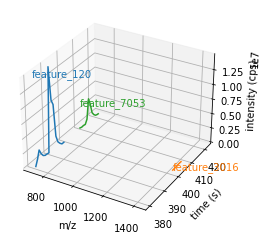

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML


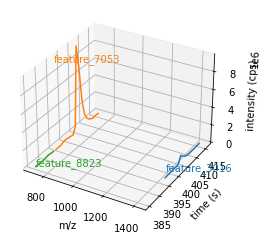

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML


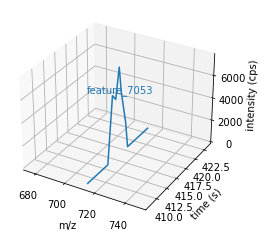

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML


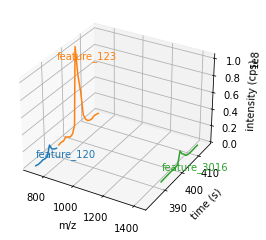

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML


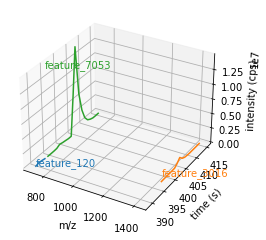

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML


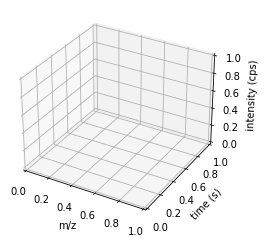

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML


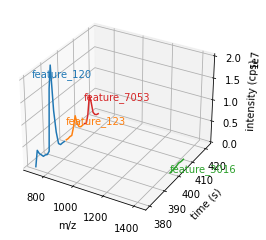

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML


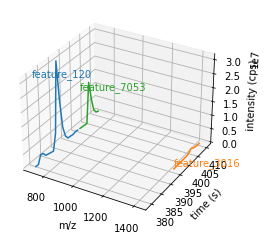

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML


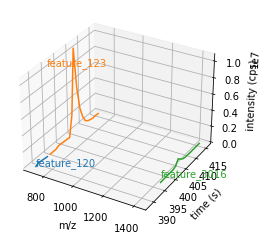

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML


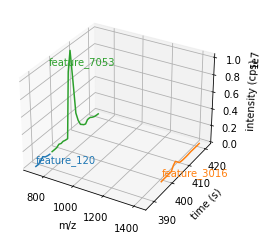

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML


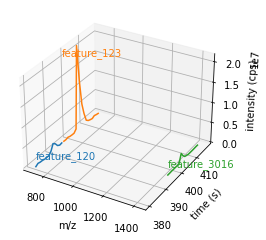

results/FFMI/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML


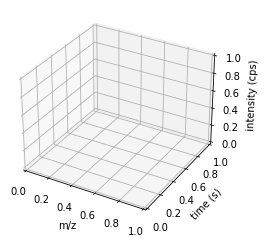

In [24]:
for filename in path:
    print(filename)
    plotDetectedFeatures3D(filename)

### Create a matrix for PCA

In [ ]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob
   
input_feature_files = sorted(glob.glob('results/Requant/interim/FFMI*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

use_centroid_rt= False
use_centroid_mz= True
protein_ids = []
peptide_ids= []

mapper = IDMapper()

input_mzml_files= sorted(glob.glob("results/Requant/interim/*.mzML"))
print(input_mzml_files)
for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)

    for fmap in feature_maps:
        if os.path.basename(fmap.getMetaValue('spectra_data')[0].decode()) == os.path.basename(filename):
            peptide_ids = []
            protein_ids = []
            
            mapper.annotate(fmap, peptide_ids, protein_ids, use_centroid_rt, use_centroid_mz, exp)
            #print(fmap.getMetaValue('spectra_data')[0].decode())
        featureidx_file = os.path.join("results", "", "Requant", "", "interim", "", 'IDMapper_' + os.path.basename(fmap.getMetaValue('spectra_data')[0].decode())[19:-5] +".featureXML")
        FeatureXMLFile().store(featureidx_file, fmap)

In [11]:
class ConsensusMapDF(ConsensusMap):
    def __init__(self):
        super().__init__()

    def get_intensity_df(self):
        labelfree = self.getExperimentType() == "label-free"
        filemeta = self.getColumnHeaders()  # type: dict[int, ColumnHeader]
        labels = list(set([header.label for header in
                           filemeta.values()]))  # TODO could be more efficient. Do we require same channels in all files?
        files = list(set([header.filename for header in filemeta.values()]))
        label_to_idx = {k: v for v, k in enumerate(labels)}
        file_to_idx = {k: v for v, k in enumerate(files)}

        def gen(cmap: ConsensusMap, fun):
            for f in cmap:
                yield from fun(f)

        if not labelfree:
            # TODO write two functions for LF and labelled. One has only one channel, the other has only one file per CF
            def extractRowBlocksChannelWideFileLong(f: ConsensusFeature):
                subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
                filerows = defaultdict(lambda: [0] * len(labels))  # TODO use numpy array?
                for fh in subfeatures:
                    header = filemeta[fh.getMapIndex()]
                    row = filerows[header.filename]
                    row[label_to_idx[header.label]] = fh.getIntensity()
                return (f.getUniqueId(), filerows)

            def extractRowsChannelWideFileLong(f: ConsensusFeature):
                uniqueid, rowdict = extractRowBlocksChannelWideFileLong(f)
                for file, row in rowdict.items():
                    row.append(file)
                    yield tuple([uniqueid] + row)

            if len(labels) == 1:
                labels[0] = "intensity"
            dtypes = [('id', np.dtype('uint64'))] + list(zip(labels, ['f'] * len(labels)))
            dtypes.append(('file', 'U300'))
            # For TMT we know that every feature can only be from one file, since feature = PSM
            #cnt = 0
            #for f in self:
            #    cnt += f.size()

            intyarr = np.fromiter(iter=gen(self, extractRowsChannelWideFileLong), dtype=dtypes, count=self.size())
            return pd.DataFrame(intyarr).set_index('id')
        else:
            # Specialized for LabelFree which has to have only one channel
            def extractRowBlocksChannelLongFileWideLF(f: ConsensusFeature):
                subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
                row = [0.] * len(files)  # TODO use numpy array?
                for fh in subfeatures:
                    header = filemeta[fh.getMapIndex()]
                    row[file_to_idx[header.filename]] = fh.getIntensity()
                yield tuple([f.getUniqueId()] + row)

            dtypes = [('id', np.dtype('uint64'))] + list(zip(files, ['f'] * len(files)))
            # cnt = self.size()*len(files) # TODO for this to work, we would need to fill with NAs for CFs that do not go over all files
            cnt = self.size()

            intyarr = np.fromiter(iter=gen(self, extractRowBlocksChannelLongFileWideLF), dtype=dtypes, count=cnt)
            return pd.DataFrame(intyarr).set_index('id')

    def get_metadata_df(self):
        def gen(cmap: ConsensusMap, fun):
            for f in cmap:
                yield from fun(f)

        def extractMetaData(f: ConsensusFeature):
            # subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
            pep = f.getPeptideIdentifications()  # type: list[PeptideIdentification]
            if len(pep) != 0:
                hits = pep[0].getHits()
                if len(hits) != 0:
                    besthit = hits[0]  # type: PeptideHit
                    # TODO what else
                    yield f.getUniqueId(), besthit.getSequence().toString(), f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()
                else:
                    yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()
            else:
                yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()

        cnt = self.size()

        mddtypes = [('id', np.dtype('uint64')), ('sequence', 'U200'), ('charge', 'i4'), ('RT', 'f'), ('mz', 'f'),
                    ('quality', 'f')]
        mdarr = np.fromiter(iter=gen(self, extractMetaData), dtype=mddtypes, count=cnt)
        return pd.DataFrame(mdarr).set_index('id')

In [12]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMapDF()
file_descriptions = consensus_map.getColumnHeaders()

input_feature_files = sorted(glob.glob('results/Requant/interim/IDMapper*.featureXML'))
print(input_feature_files)

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = feature_map.getMetaValue('spectra_data')[0].decode()
    print(file_description.filename)

    file_description.size = feature_map.size()
    # file_description.unique_id = feature_map.getUniqueId() doesn't work on windows
    #print(file_description.unique_id)
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)

Consensus_file= os.path.join("results", "", "Requant", "","interim", "", 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)

# get intensities as a DataFrame
intensities = consensus_map.get_intensity_df()

# get meta data as DataFrame
meta_data = consensus_map.get_metadata_df()[['RT', 'mz', 'charge']]

# you can concatenate these two for a "result" DataFrame
result = pd.concat([meta_data, intensities], axis=1)

# if you don't need labeled index, remove it (and/or save with index = False)
result.reset_index(drop=True, inplace=True)

# store as tsv file
result.to_csv('results/Requant/FeatureMatrix.tsv', sep = '\t', index = False)

['results/Requant/interim/IDMapper__UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML', 'results/Requant/interim/IDMapper__UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML', 'r

In [ ]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob
import matplotlib

Preprocessed= glob.glob("results/features/*.csv")
Requantified= glob.glob("results/Requant/*csv")

for table in Preprocessed:
    df1= pd.read_csv(table)
    feature_no= len(df1)
    for matrix in Requantified:
        df2= pd.read_csv(matrix)
        requant_no= len(df2)
        if os.path.basename(matrix)= os.path.basename(table):
